# Estimate of Optical Depth.

A rough estimate for the optical depth to strong gravitational lensing is

$$  \large
\tau = \frac{N_\text{lens}}{N_\text{GRB}} , 
$$

where $N_\text{lens}$ is the number of multiply-imaged GRBs and $N_\text{GRB}$ is the total number of GRBs in our dataset.
We find $N_\text{lens}=1$ lensed GRB in a dataset of $N_\text{GRB}=2,679$, so the lens probability is 

$$P(\tau)\sim\tau= 3.7^{+7.8}_{-2.6}\times10^{-4} \text{ (90% credibility)}, $$

where we have used a Jeffreys prior.
We may relate the energy density of lenses to the optical depth, 

$$ \large
\Omega_l\sim\tau \left(\left<z_s\right>\right)
$$ 

where $\left<z_s\right>$ is the mean redshift of sources in the sample. 


### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.integrate as integrate
from scipy.optimize import fsolve
import math

from decimal import Decimal
from scipy.stats import poisson
from PyGRB.utils.utils import label_axes, tabulate_data

In [2]:
import matplotlib as mpl
from matplotlib import rc
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
rc('font',**{'family':'DejaVu Sans','serif':['Computer Modern'], 'size':12})
rc('text', usetex=True)


### Magic numbers

In [3]:
const_G = 6.6741e-11 # SI units
const_c = 299792458.  # m/s
omega_m = 0.286
omega_v = 0.714
H_0     = 69600. #/ 3.086e22    # m/s / Mpc
MPC_2_M = 3.086e22
msun_2_kg = 1.98e30 

GRB_LUMINOSITY = 10**44 # Watts
# GRB_LUMINOSITY = 10**44.5 # Watts
ENERGY_TO_GAMMA = 1.602e-14 # Watts to 100 kev phot / sec
PHI_0 = 0.3 # photons / cm^2 / sec (BATSE minimum detectable photon flux)
LENS_MASS = 5.5e4 #* 1.98e30 # kg
MIN_TIME_DELAY = 1e-2 # second
MAX_TIME_DELAY = 240 # second
SOURCE_REDSHIFT = 5
C_MAX_C_MIN = 2

## Cosmology

For a point mass and a point lens, the angular Einstein radius of the lens $\theta_E$ is

$$ \large
\theta_E^2 = \frac{4GM_l}{c^2} \frac{d_A(z_l,z_s)} {d_A(z_l)d_A(z_s)}. 
$$

Here, $G$ is the gravitational constant, $c$ the speed of light, and $M_l$ the mass of the gravitational lens.

In [4]:
def einstein(mass, z_l, z_s):
    """ The Einstein radius of a point lens at redshift z_l for a source at redshift z_s.
    
        Parameters
        ----------
        mass : float
            The mass of the point lens in solar masses.
        z_l  : float
            The redshift of the lens.
        z_s  : float
            the redshift of the source.

        Returns
        -------
        float
            The Einstein radius (unitless).
    
    """
    dist = ((1 + z_l) * (vector_pd(z_s) - vector_pd(z_l)) /
            (vector_pd(z_s) * vector_pd(z_l))               ) # Mpc
    return np.sqrt(4 * const_G * mass * msun_2_kg / math.pow(const_c, 2) * dist / MPC_2_M) # unitless / angle

The angular diameter distances are defined as

$$ \large
d_A(z_l,z_s)=\frac{\chi(z_s)-\chi(z_l)}{1+z_s},
$$

In [5]:
def angular_diameter_distance(z):
    """ Returns angular diameter distance in Mpc.
    
        Parameters
        ----------
        z : float
            The redshift to calculate the angular diameter distance for.

        Returns
        -------
        float
            The angular diameter distance in units of Mpc.
    
    """
    return proper_distance(z) / (1 + z)

with proper comoving distance

$$ \large 
\chi(z_l,z_s) = \frac{c}{H_0}\int_{z_l}^{z_s} \frac{dz}{\sqrt{\Omega_\Lambda+\Omega_m(1+z)^3}}. 
$$

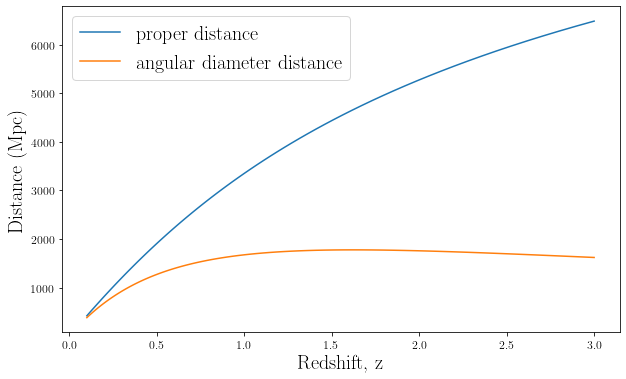

In [6]:
def proper_distance(z):
    """ Integrates the Hubble function to find the proper distance out to redshift z. Returns proper distance in Mpc.
    
        Parameters
        ----------
        z : float
            The redshift to calculate the proper distance for.

        Returns
        -------
        float
            The proper distance chi in units of Mpc.
    
    """
    def func(z):
        integral, err = integrate.quad(lambda x:  math.pow(math.pow((1 + x), 3)
                                                * omega_m + omega_v, -0.5), 0, z)
        return const_c / H_0 * integral

    vfunc = np.vectorize(func)
    return vfunc(z)



z = np.geomspace(0.1,3,100)
fig,ax = plt.subplots(figsize = (10,6))
ax.plot(z, proper_distance(z), label = "proper distance")
ax.plot(z, angular_diameter_distance(z), label = "angular diameter distance")
ax.set_xlabel("Redshift, z", fontsize = 20)
ax.set_ylabel("Distance (Mpc)", fontsize = 20)
ax.legend(fontsize = 20)
plt.show()

## Lensing

We take $\Omega_\Lambda = 0.714$, and $\Omega_m = 0.286$, with present day Hubble constant $H_0=69.6$ km s$^{-1}$ Mpc$^{-1}$.

The angular impact parameter $\beta$ of the true position of the source to the lens can be parameterised in units of the Einstein radius, $y\equiv \beta/\theta_E$.
Such a configuration creates two images, with time delay given by

$$ \large
    \Delta t (M_l, z_l, y) =
    (1+z_l) \frac{4GM_l}{c^3} f(y)
$$
where
$$ \large
f(y) = \left( \frac{y}{2}\sqrt{y^2+4} + \ln{\frac{\sqrt{y^2+4}+y}{\sqrt{y^2+4}-y}}. \right)
$$

### To Python
Here we define several helper functions to break up the maths

magnification y:
$$ \large f_\text{mag y} = \log{\left(\frac{\sqrt{y^2+4}+y}{\sqrt{y^2+4}-y}\right)} $$ 

In [7]:
def magnification_y(y):
    """ A helper function for calculation the time delay from the lensing parameters.

    Parameters
    ----------
    y : float
        The scaled impact parameter, y = beta / theta_E.

    Returns
    -------
    float
        The evaluation of the function.
    
    """
    def func(y):
        return (math.log( math.sqrt(math.pow(y,2) + 4) + y) -
                math.log( math.sqrt(math.pow(y,2) + 4) - y) )
    vfunc = np.vectorize(func)
    return vfunc(y)

y function:
$$ \large f_\text{y func} = \frac{y}{2}\sqrt{y^2+4} + f_\text{mag y} $$ 

In [8]:
def y_function(y):
    """ A helper function for calculation the time delay from the lensing parameters.

    Parameters
    ----------
    y : float
        The scaled impact parameter, y = beta / theta_E.

    Returns
    -------
    float
        The evaluation of the function.
    
    """
    def func(y):
        return (y/2 * math.sqrt(math.pow(y,2) + 4) + magnification_y(y))
    vfunc = np.vectorize(func)
    return vfunc(y)

time delay function:

$$ \large f_\text{$\Delta$t} = \frac{4 GM}{c^3} (1+z_l) f_\text{y func}  $$


In [9]:
def time_delay_function(mass, z_l, y):
    """ Calculates the time delay from the lensing parameters.

    Parameters
    ----------
    mass : float
        The mass of the point lens in solar masses.
    z_l  : float
        The redshift of the lens.
    z_s  : float
        the redshift of the source.

    Returns
    -------
    float
        The time delay (seconds).
    
    """
    return 4 * (1 + z_l) * const_G * mass * msun_2_kg * y_function(y) / (const_c ** 3)

A source with angular impact parameter $\beta$ has an effective lensing cross-section of

$$ \large
\begin{align}
    \int \sigma &= \int_{\beta_\text{min}}^{\beta_\text{max}} 2 \pi \beta \, d \beta  \\
    \\
    &= \pi \theta_E^2 \int_{y_\text{min}}^{y_\text{max}} 2y dy  \\
    \\
    &= \frac{4\pi G M_l}{c^2} \frac{d_A(z_l,z_s)} {d_A(z_l)d_A(z_s)} \int_{y_\text{min}}^{y_\text{max}} 2y \, dy .
\end{align}
$$

Thus, $y_\text{min}$ and $y_\text{max}$  turn the cross-section into an annulus.
The minimum impact parameter is set by the time delay between the arrival times of the two images.
If the time delay is too short, the images will appear as single gamma-ray burst.
For a point lens, we may calculate the minimum time delay for a lens of mass $M_l$ at redshift $z_l$ by inverting the time delay equation,

$$ \large
y_\text{min}(\Delta t_\text{min}, M_l, z_l) = f^{-1}\left(\frac{c^3\Delta t_\text{min}}{(1+z_l)4GM_l}\right),
$$

since $f(y)$ is monotonic increasing in $y$.
We take $\Delta t_\text{min} = 10$ ms.

In [10]:
def y_from_Delta_t(mass, z_l, Delta_t):
    """ Calculates y from the time delay given the lensing parameters.

    Parameters
    ----------
    mass : float
        The mass of the point lens in solar masses.
    z_l  : float
        The redshift of the lens.
    Delta_t  : float
        the time delay between the two images.

    Returns
    -------
    float
        The dimensionless impact parameter y.
    
    """
    def yfunc(mass, z_l, Delta_t):
        """ helper function to vectorise. """
        def func(y):
            """ helper function to solve. """
            return Delta_t - time_delay_function(mass, z_l, y)
        y = fsolve(func, 100)
        return y
    vfunc = np.vectorize(yfunc)
    return vfunc(mass, z_l, Delta_t)

[a] = y_from_Delta_t(mass = 1e6, z_l = 1, Delta_t = 82)
print(f'The impact parameter of a source lensed by a million solar mass black hole')
print(f'at redshift z_l = 1 with time delay 82 seconds is {a:.2f} einstein radii.')

The impact parameter of a source lensed by a million solar mass black hole
at redshift z_l = 1 with time delay 82 seconds is 1.00 einstein radii.


 
The latter-arriving image is dimmer than the first image but must still be above the detectable flux for the detector, $\mu_2\varphi_\text{peak}>\varphi_0$, where $\mu_2$ is the magnification of the dimmer image.
This restricts the maximum possible impact parameter,

$$ \large
y_\text{max}(\varphi_\text{peak}) = \left(1 + \frac{\varphi_\text{peak}}{\varphi_0} \right)^{1/4} - \left(1 + \frac{\varphi_\text{peak}}{\varphi_0} \right)^{-1/4},
$$

where $\varphi_\text{peak}/\varphi_0$ is the peak counts divided by the trigger threshold at that time.

The peak flux is found from the emitted flux through

$$ \large
\varphi_\text{peak} = \frac{\varphi_\text{emit}}{4 \pi d_L^2(z_s)},
$$

where $d_L(z)$ is the luminosity distance defined by $d_L(z)=(1+z)\chi(z)$.

$$ \large
        f(\varphi) = \left\{
                \begin{array}{ll}
                  1-e^{- (\varphi - \varphi_0)/\alpha}, \qquad &\varphi > \varphi_0,\\
                  0, \qquad &\text{otherwise}.
                \end{array}
              \right.
$$

In [11]:
def y_max(z_s, phi_emit, **kwargs):
    """ Calculates y_max from the given parameters.

    Parameters
    ----------
    z_s  : float
        The redshift of the source.
    phi_emit  : float
        The GRB emission flux in Watts / m^2.
        
    Optional Parameters
    -------------------
    phi_0  : float
        The minimum detectable photon flux at the detector in photons / sec / cm^2.
    cmax  : float

    Returns
    -------
    float
        The maximum detectionable dimensionless impact parameter for the given input variables.
    
    """
    phi_emit/= ENERGY_TO_GAMMA # convert Joules / sec into photons / sec (assuming 100 keV photons)
    phi_emit/= 1e4 # convert / m^2 to cm^2
    phi_0    = kwargs.pop('phi_0', PHI_0)
    phi_peak = phi_emit / (4 * np.pi * (proper_distance(z_s) * (1 + z_s) * MPC_2_M)**2)
    cmax = kwargs.pop('cmax', None)
    if cmax:
        try:
            phi_ratio = cmax * np.ones(len(z_s))
        except:
            phi_ratio = cmax
        ymax =  ( np.power(1 + phi_ratio,  0.25)
                - np.power(1 + phi_ratio, -0.25))
    else:
        ymax =  ( np.power(1 + phi_peak / phi_0,  0.25)
                - np.power(1 + phi_peak / phi_0, -0.25))
    return  ymax


def y_bounds(z_l, z_s, bounds = False, **kwargs):
    """ Calculates the limits of y integration from the given parameters.

    Parameters
    ----------
    z_l : float
        The redshift of the lens.
    z_s : float
        The redshift of the source.
    bounds : bool
        If true returns the y bounds. If false evaluates the y integral of the cross-section.
        
    Optional Parameters
    -------------------
    Delta_t_min : float
        The minimum detecable time delay (seconds). 
        Defaults to the magic number MIN_TIME_DELAY defined at the top of the notebook.
        
    Delta_t_max : float
        The maximum detecable time delay (seconds). 
        Defaults to the magic number MAX_TIME_DELAY defined at the top of the notebook.
        
    mass : float
        The mass of the point lens in solar masses. 
        Defaults to the magic number LENS_MASS defined at the top of the notebook.
               
    luminosity : float
        The GRB emission luminosity in Watts / m^2. 
        Defaults to the magic number GRB_LUMINOSITY defined at the top of the notebook.
        
    phi_0 : float
        The minimum detectable photon flux at the detector in photons / sec / cm^2. 
        Defaults to the magic number PHI_0 defined at the top of the notebook.

    Returns
    -------
    float
        The maximum detectionable dimensionless impact parameter for the given input variables.
    
    """
    Delta_t_min = kwargs.pop('Delta_t_min', MIN_TIME_DELAY)
    Delta_t_max = kwargs.pop('Delta_t_max', MAX_TIME_DELAY)
    mass        = kwargs.pop('mass', LENS_MASS)
    luminosity  = kwargs.pop('luminosity', GRB_LUMINOSITY)
    phi_0       = kwargs.pop('phi_0', PHI_0)
    
    y_a = y_max(z_s, phi_emit = luminosity, phi_0 = phi_0, **kwargs)
    y_b = y_from_Delta_t(z_l = z_l,
        Delta_t = Delta_t_max, mass = mass)
    ymax = np.minimum.reduce([y_a, y_b])
    ymin = y_from_Delta_t(z_l = z_l,
        Delta_t = Delta_t_min, mass = mass)
    if bounds:
        return ymin, ymax, y_a, y_b
    else:
        return (ymax**2 - ymin**2) * np.heaviside(ymax - ymin, 0)

We estimate $y_\text{max}$ with medians of the $\varphi_\text{peak}/\varphi_0$ for the peak flux on 64 ms, 256 ms, and 1024 ms integrations from the BATSE C$_\text{max}$ table, which are 1.5, 2.2, and 2.5 respectively.

https://gammaray.nsstc.nasa.gov/batse/grb/catalog/4b/tables/4br_grossc.cmaxmin

The final cross section is then

$$ \large
\begin{equation}
    \sigma(\textbf{x}) = \frac{4\pi G M_l}{c^2} \frac{d_A(z_l,z_s)} {d_A(z_l)d_A(z_s)} 
    \left(y_\text{max}^2-y_\text{min}^2\right)
    \Theta\left(y_\text{max}-y_\text{min}\right)
\end{equation}
$$

where $\textbf{x} \equiv (M_l, z_l, z_s, \varphi_\text{peak}, \varphi_0, \Delta t_\text{min})$ and $\Theta$ is the Heaviside step function.

## Optical Depth

The optical depth is the number density $n(z_l)$ of lenses at redshift $z_l$, multiplied by the effective lensing cross-section of each lens $\sigma(\vec{x})$, integrated over $z\in(0,z_s)$:

$$ \large
\begin{equation}
    \tau(\textbf{x}) = \frac{1}{d\Omega} \int_0^{z_s} dV(z_l) \, n_l(z_l) \int d\sigma (\textbf{x}) . 
\end{equation}
$$

We assume a constant comoving density of lenses, 

$$ \large
n_l(z_l)=n_0.
$$

The number density of lenses can be related to their energy density $\Omega_l$ through 
$$ \large
n_0 = \frac{\rho_c\Omega_l}{M_l} = \frac{3H_0^2\Omega_l}{8\pi G M_l} 
$$

With comoving volume element

$$ \large
\begin{align}
    dV(z) &= \chi^2(z) \frac{d \chi(z)}{dz}  \,dz d\Omega \nonumber \\
    &= \chi^2(z) \frac{c}{H_0} \frac{dz \, d\Omega}{\sqrt{\Omega_\Lambda + \Omega_m (1+z)^3}},
\end{align}
$$

we have

$$ \large
\begin{align}
    \tau(\vec{x}) &=\frac{3H_0\Omega_l}{2 c \chi(z_s)} \int_0^{z_s} dz_l \frac{(1+z_l)\chi(z_l)}{\sqrt{\Omega_\Lambda + \Omega_m (1+z_l)^3}}[\chi(z_s)-\chi(z_l)] \nonumber \\
    &\quad \cdot \left[
    y^2_\text{max}(\varphi_\text{peak},\varphi_0) - y^2_\text{min}(\Delta t_\text{min}, M_l, z_l)\right] .
\end{align}
$$

With an estimated lens probability of $P(\tau)\sim\tau\approx3.7\times10^{-4}$, we infer the lens density through inverting this last equation.

In [12]:
def hubble(z):
    """ Calculates H(z) from z.

    Parameters
    ----------
    z : float
        The redshift.

    Returns
    -------
    float
        The hubble function evaluated at z.
        
    """
    return np.power(np.power((1 + z), 3) * omega_m + omega_v, -0.5)

def redshift_integral(z, **kwargs):
    """ Calculates the redshift integral.

    Parameters
    ----------
    z : float
        The redshift of the source.
    bounds : bool
        If true returns the y bounds. If false evaluates the y integral of the cross-section.
        
    Optional Parameters
    -------------------
    Delta_t_min : float
        The minimum detecable time delay (seconds). 
        Defaults to the magic number MIN_TIME_DELAY defined at the top of the notebook.
        
    Delta_t_max : float
        The maximum detecable time delay (seconds). 
        Defaults to the magic number MAX_TIME_DELAY defined at the top of the notebook.
        
    mass : float
        The mass of the point lens in solar masses. 
        Defaults to the magic number LENS_MASS defined at the top of the notebook.
        
    phi_0 : float
        The minimum detectable photon flux at the detector in photons / sec / cm^2. 
        Defaults to the magic number GRB_LUMINOSITY defined at the top of the notebook.
        
    luminosity : float
        The GRB emission luminosity in Watts / m^2. 
        Defaults to the magic number PHI_0 defined at the top of the notebook.

    Returns
    -------
    float
        The maximum detectionable dimensionless impact parameter for the given input variables.
    
    """
    def func(z, **kwargs):                          
        integral, err = integrate.quad(lambda x: (1 + x) * proper_distance(x) *
        (proper_distance(z) - proper_distance(x)) *
        hubble(x) *
        y_bounds(x, z, **kwargs), 0, z, points =
        [0, 1e-100, 1e-50, 1e-20, 1e-10, 1e-5, 1, z])
        return integral
    vfunc = np.vectorize(func)
    return vfunc(z, **kwargs)

def optical_depth(mass_density, source_redshift, **kwargs):
    """ Calculates the optical depth from the given parameters.

    Parameters
    ----------
    mass_density : float
        The mass density.
    source_redshift  : float
        The source redshift.
        
    Optional Parameters
    -------------------
    Delta_t_min : float
        The minimum detecable time delay (seconds). 
        Defaults to the magic number MIN_TIME_DELAY defined at the top of the notebook.
        
    Delta_t_max : float
        The maximum detecable time delay (seconds). 
        Defaults to the magic number MAX_TIME_DELAY defined at the top of the notebook.
        
    mass : float
        The mass of the point lens in solar masses. 
        Defaults to the magic number LENS_MASS defined at the top of the notebook.
        
    phi_0 : float
        The minimum detectable photon flux at the detector in photons / sec / cm^2. 
        Defaults to the magic number GRB_LUMINOSITY defined at the top of the notebook.
        
    luminosity : float
        The GRB emission luminosity in Watts / m^2. 
        Defaults to the magic number PHI_0 defined at the top of the notebook.

    cmax  : float

    Returns
    -------
    float
        The hubble function evaluated at z.
        
    """
    integral = redshift_integral(source_redshift, **kwargs)
    return 3 * H_0 * mass_density * integral / (
                2 * const_c * proper_distance(source_redshift))

In [13]:
def poiss_er(lllambda = 1):
    dr = 1e-3
    r  = np.linspace(dr, 20, int(20/dr))

    L = poisson.pmf(1, r)

    prior = 1 / np.sqrt(r)
    norm_prior = prior / (np.sum(prior) * dr)

    post = prior * L
    norm_post = post / (np.sum(post) * dr)

    # cdf
    post_cdf = np.cumsum(norm_post * dr)
    idx = np.arange(len(r))
    plt.scatter(idx, post_cdf, marker = '.', s = 10)
    idx_min = np.min(idx[post_cdf > 0.10])
    idx_max = np.max(idx[post_cdf < 0.90])
    r = r * lllambda
    return lllambda, r[idx_max] - lllambda, lllambda - r[idx_min]

def number_density(omega, z, mass = LENS_MASS):
    mass_l = mass / (1 + (z/2)) * msun_2_kg
    rho_crit = 3 * H_0**2 / (8 * np.pi * const_G) * MPC_2_M
    n = omega / mass_l * rho_crit
    a, b, c = poiss_er(n)
    return a, b, c

def one_cred(z, omega, threshold):
    dlambda = 1e-6
    llambda = np.linspace(dlambda, 10, int(10/dlambda))
    p = poisson.pmf(1, llambda)
    prior = 1 / np.sqrt(llambda)
    p2 = prior * p
    norm_p = p2 / np.sum(p2 * dlambda)

    threshold = threshold / omega
    credibility = np.sum(dlambda * p2[llambda < threshold])
    cred = 100*(1-credibility)
    return cred

def credibility(zeds, omegas):
    cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

    
    fig, ax = plt.subplots(figsize = (8,5))
    ax.plot(llambda, norm_p, c = 'k')

    lums = [1e43, 1e44, 1e45, 1e46, 1e47]
    threshold = 8e-6
    for i, (z, omega) in enumerate(zip(zeds, omegas)):
        cred = one_cred(z, omega, threshold)
        print(f'At <z_s> = {z} a globular cluster is excluded at {cred:.5f}% credibility')
        ax.axvline(threshold, color = cols[i], linestyle = ':',
            label = f'$\\Omega_\\text{{gc}}/\\Omega_l$ for $\\left<z_s\\right>\\sim{z}$')
    ax.set_xscale('log')
    ax.set_xlabel(r'$X\sim$ Poisson$(N=1)$')
    ax.set_ylabel('Probability Density')
    ax.legend(loc = 'upper left')
    return creds

def error_bars(x, x_up, x_down):
    power = int( math.log10(x))
    if power < 1:
        power -= 1
    x_pow = 10**( power )
    x /= x_pow
    x_up /= x_pow
    x_down /= x_pow
    return f'{x:.1f} + {x_up:.1f} - {x_down:.1f} x 10^{int(math.log10(x_pow))}'


def make_pretty_table(table_data):
    from prettytable import PrettyTable
    x = PrettyTable(['z', 'omega_lens', 'n', 'gc_exlusion'], hrules = 1)
    x.align['z'] = "l" # left align     
    x.padding_width = 1
    for key, table_row in table_data.items():
        o_text = error_bars(table_row['omega_lens'], table_row['omega_lens_plus'], table_row['omega_lens_minus'])
        n_text = error_bars(table_row['n'], table_row['n_up'], table_row['n_down'])
        x.add_row([table_row['z'], o_text, n_text, f"{table_row['gc_exlusion']}%"])
    return x


cmax / cmin = 1.5
+------+--------------------------+-------------------------+--------------------+
| z    |        omega_lens        |            n            |    gc_exlusion     |
+------+--------------------------+-------------------------+--------------------+
| 0.1  | 5.0 + 10.6 - 3.5 x 10^-1 |  1.3 + 2.7 - 0.9 x 10^6 | 99.99999595311814% |
+------+--------------------------+-------------------------+--------------------+
| 0.5  | 2.9 + 6.1 - 2.0 x 10^-2  | 8.9 + 18.9 - 6.3 x 10^4 | 99.99969355696295% |
+------+--------------------------+-------------------------+--------------------+
| 1    | 8.0 + 17.0 - 5.6 x 10^-3 |  2.9 + 6.2 - 2.1 x 10^4 | 99.99788519749028% |
+------+--------------------------+-------------------------+--------------------+
| 1.34 | 4.8 + 10.3 - 3.4 x 10^-3 |  2.0 + 4.2 - 1.4 x 10^4 | 99.99553013628906% |
+------+--------------------------+-------------------------+--------------------+
| 2.0  | 2.6 + 5.6 - 1.8 x 10^-3  |  1.3 + 2.7 - 0.9 x 10^4 | 99.9887

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


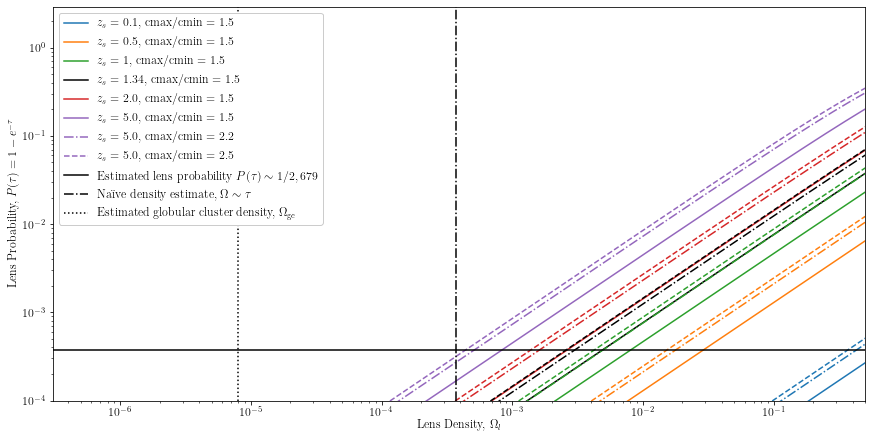

In [14]:
def main(**kwargs):
    z_s = kwargs.get('source_redshift', SOURCE_REDSHIFT)
    Delta_t_min = kwargs.get('Delta_t_min', MIN_TIME_DELAY)
    Delta_t_max = kwargs.get('Delta_t_max', MAX_TIME_DELAY)
    l = kwargs.get('luminosity', GRB_LUMINOSITY)
    m = kwargs.get('mass', LENS_MASS)
    phi = kwargs.get('detection_counts', PHI_0)

    fig, ax = plt.subplots(figsize = (12,6), constrained_layout = True)
    zeds = [0.1, 0.5, 1, 1.34, 2., 5.]
    cols = ['tab:blue', 'tab:orange', 'tab:green', 'k', 'tab:red', 'tab:purple']
    ls = ['-', '-.', '--', ':']
    cmaxs = [1.5, 2.2, 2.5]

    mass_density = np.geomspace(1e-6,5e-1, 1000)
    
    table_values = dict()

    for k, c in enumerate(cmaxs):
        omegas = []
        print(f'cmax / cmin = {c}')
        for i, z_s in enumerate(zeds):
            opt_depth = optical_depth(  mass_density, z_s,
                                        mass = m,
                                        luminosity = l,
                                        Delta_t_min = Delta_t_min,
                                        Delta_t_max = Delta_t_max,
                                        cmax = c,
                                        )
            label = ''
            if c == 1.5 or z_s == 5:
                label += f'$z_s = {z_s}$'
                label += f', cmax/cmin = {c}'
            prob = 1 - np.exp(- opt_depth)
            ax.plot(mass_density, prob,
                    c = cols[i], linestyle = ls[k],
                    label = label,
                    )
            omega = mass_density[np.argmin(np.abs(opt_depth - 1/2679))]
            omegas.append(omega)
            
            _, omega_up, omega_down = poiss_er(omega)
            n, n_up, n_down = number_density(omega, z_s)
            
            table_row = dict()
            table_row['z'] = z_s
            table_row['omega_lens'] = omega
            table_row['omega_lens_plus'] = omega_up
            table_row['omega_lens_minus'] = omega_down
            
            table_row['n'] = n
            table_row['n_up'] = n_up
            table_row['n_down'] = n_down

            cred = one_cred(z, omega, 8e-6)
            table_row['gc_exlusion'] = cred
                      
            table_values[f'z = {z_s:.1f}'] = table_row
        table = make_pretty_table(table_values)
        print(table)


    ax.axhline(1/2679, color = 'k',
    label = r'Estimated lens probability $P(\tau)\sim 1/2,679$')
    ax.axvline(1/2679, color = 'k', linestyle = '-.',
    label = r'Na\"ive density estimate, $\Omega\sim\tau$')
    ax.axvline(8e-6, color = 'k', linestyle = ':',
    label = r'Estimated globular cluster density, $\Omega_\text{gc}$')
    ax.set_xlabel(r'Lens Density, $\Omega_l$')
    ax.set_ylabel(r'Lens Probability, $P(\tau) = 1 - e^{-\tau}$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(right = np.max(mass_density))
    ax.set_ylim(bottom = 1e-4)
    ax.legend(framealpha = 1, facecolor = 'white')
    
main()